In [1]:
import pandas as pd
import numpy as np
from os.path import join
import matplotlib.pyplot as plt

In [2]:
def evaluate(model, X, gt_df):
    pred = model.predict(X)
    answ = pd.concat([gt_df.reset_index()[['Date_round', 'Perf_1Y']], pd.Series(pred, name='pred')],axis=1)
    gts = answ.groupby('Date_round').apply(lambda x: x.Perf_1Y.to_numpy())
    preds = answ.groupby('Date_round').apply(lambda x: x.pred.to_numpy())
    concated_gts_preds = pd.concat([gts, preds], axis=1)

    rmse = concated_gts_preds.apply(lambda x: np.sqrt(mean_squared_error(x[0], x[1])), axis=1)
    p_pred = concated_gts_preds.apply(lambda x: ((x[0] * x[1]) > 0).sum()/x[0].shape[0], axis=1)
    ndcgs = concated_gts_preds.apply(lambda x: ndcg_score([x[0].argsort()[::-1]], [x[1]]), axis=1)

    res_df = pd.concat([rmse, p_pred, ndcgs], axis=1)
    res_df.columns = ['rmse', 'p_pred', 'ndcgs']
    return res_df


In [3]:
data_path = 'data'

In [4]:
data = pd.read_csv(join(data_path, 'clear_outliers.csv'), parse_dates=['Date_round'])
print(data.shape)
data.isna().sum()

(1178362, 22)


Price_To_Tangible_Book_Value_Per_Share       0
C_Price_To_Tangible_Book_Value_Per_Share     0
Price_To_Book_Value_Per_Share                0
C_Price_To_Book_Value_Per_Share              0
Enterprise_Value_to_Sales                    0
Price_To_Sales_Per_Share                     0
Company_Shares                               0
Enterprise_Value                             0
Free_Cash_Flow_net_of_Dividends_per_Share    0
C_Price_to_FCF_net_of_Dividends_per_Share    0
Enterprise_Value_to_EBITDA                   0
Enterprise_Value_to_Operating_Cash_Flow      0
Price_to_Cash_Flow_per_Share                 0
P_to_E                                       0
Date_round                                   0
RanksID                                      0
Perf_1Y                                      0
gicsSectorName                               0
gicsIndustryGroupName                        0
gicsIndustryName                             0
gicsSubIndustryName                          0
Country_of_He

In [5]:
test = pd.read_csv(join(data_path, 'clear_test_outliers.csv'), parse_dates=['Date_round'])
print(test.shape)
test.isna().sum()

(232010, 22)


Price_To_Tangible_Book_Value_Per_Share       0
C_Price_To_Tangible_Book_Value_Per_Share     0
Price_To_Book_Value_Per_Share                0
C_Price_To_Book_Value_Per_Share              0
Enterprise_Value_to_Sales                    0
Price_To_Sales_Per_Share                     0
Company_Shares                               0
Enterprise_Value                             0
Free_Cash_Flow_net_of_Dividends_per_Share    0
C_Price_to_FCF_net_of_Dividends_per_Share    0
Enterprise_Value_to_EBITDA                   0
Enterprise_Value_to_Operating_Cash_Flow      0
Price_to_Cash_Flow_per_Share                 0
P_to_E                                       0
Date_round                                   0
RanksID                                      0
Perf_1Y                                      0
gicsSectorName                               0
gicsIndustryGroupName                        0
gicsIndustryName                             0
gicsSubIndustryName                          0
Country_of_He

In [6]:
valid_columns = ['Date_round', 'RanksID', 'Perf_1Y', 'Country_of_Headquarters',
       'Price_To_Tangible_Book_Value_Per_Share',
       'C_Price_To_Tangible_Book_Value_Per_Share',
       'Price_To_Book_Value_Per_Share', 'C_Price_To_Book_Value_Per_Share',
       'Enterprise_Value_to_Sales', 'Price_To_Sales_Per_Share',
       'Company_Shares', 'MCap_group', 'Enterprise_Value', 'gicsSectorName',
       'gicsIndustryGroupName', 'gicsIndustryName', 'gicsSubIndustryName',
       'Free_Cash_Flow_net_of_Dividends_per_Share',
       'C_Price_to_FCF_net_of_Dividends_per_Share',
       'Enterprise_Value_to_EBITDA', 'Enterprise_Value_to_Operating_Cash_Flow',
       'Price_to_Cash_Flow_per_Share', 'P_to_E']

gics_names = ['gicsSectorName', 'gicsIndustryGroupName','gicsIndustryName','gicsSubIndustryName']

useless_columns = ['MCap_group']

util_columns = ['Date_round', 'RanksID', 'Perf_1Y']
cat_columns = gics_names + ['Country_of_Headquarters']
reg_columns = [el for el in valid_columns if el not in useless_columns + cat_columns + util_columns]

In [7]:
import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, ndcg_score
from sklearn.metrics import r2_score

In [8]:
scaler = StandardScaler()

X_train, y_train = data[cat_columns + reg_columns], data.Perf_1Y
X_test, y_test = test[cat_columns + reg_columns], test.Perf_1Y

X_train.loc[:, reg_columns] = scaler.fit_transform(X_train.loc[:, reg_columns].to_numpy())
X_test.loc[:, reg_columns] = scaler.transform(X_test.loc[:, reg_columns].to_numpy())

train_dataset = cb.Pool(X_train, y_train, cat_features=cat_columns)
test_dataset = cb.Pool(X_test, y_test, cat_features=cat_columns)

/var/folders/6j/p61nyxsx25xd2l5m0h0g5bm80000gn/T/ipykernel_10241/3654358756.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:, reg_columns] = scaler.fit_transform(X_train.loc[:, reg_columns].to_numpy())
/var/folders/6j/p61nyxsx25xd2l5m0h0g5bm80000gn/T/ipykernel_10241/3654358756.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, reg_columns] = scaler.transform(X_test.loc[:, reg_columns].to_numpy())


In [9]:
model = cb.CatBoostRegressor(loss_function='MAE',
                             iterations=50)
model.fit(train_dataset, eval_set=test_dataset)

0:	learn: 0.4080581	test: 0.4584398	best: 0.4584398 (0)	total: 451ms	remaining: 22.1s
1:	learn: 0.4077055	test: 0.4583867	best: 0.4583867 (1)	total: 757ms	remaining: 18.2s
2:	learn: 0.4073799	test: 0.4583519	best: 0.4583519 (2)	total: 1.05s	remaining: 16.4s
3:	learn: 0.4070616	test: 0.4583041	best: 0.4583041 (3)	total: 1.35s	remaining: 15.5s
4:	learn: 0.4067636	test: 0.4582699	best: 0.4582699 (4)	total: 1.63s	remaining: 14.7s
5:	learn: 0.4064873	test: 0.4582410	best: 0.4582410 (5)	total: 1.91s	remaining: 14s
6:	learn: 0.4062213	test: 0.4582139	best: 0.4582139 (6)	total: 2.25s	remaining: 13.8s
7:	learn: 0.4059711	test: 0.4581443	best: 0.4581443 (7)	total: 2.56s	remaining: 13.4s
8:	learn: 0.4057174	test: 0.4580747	best: 0.4580747 (8)	total: 2.89s	remaining: 13.2s
9:	learn: 0.4054777	test: 0.4580070	best: 0.4580070 (9)	total: 3.19s	remaining: 12.8s
10:	learn: 0.4052601	test: 0.4580111	best: 0.4580070 (9)	total: 3.51s	remaining: 12.4s
11:	learn: 0.4050503	test: 0.4579230	best: 0.4579230 (1

In [10]:
res_df = evaluate(model, X_train, data.reset_index()[['Date_round', 'Perf_1Y']])
mean_res = res_df.mean()
print(f'Train score.\n'
      f'{res_df}\n\n'
      f'RMSE: {round(mean_res.rmse, 3)}\n'
      f'p_pred: {round(mean_res.p_pred, 3)}\n'
      f'ndcg: {round(mean_res.ndcgs, 3)}')

Train score.
                rmse    p_pred     ndcgs
Date_round                              
2007-04-01  0.925122  0.513156  0.934248
2007-07-01  0.814860  0.709057  0.934274
2007-10-01  0.502136  0.865419  0.934594
2008-01-01  0.576517  0.958933  0.935313
2008-04-01  0.521787  0.953235  0.936133
2008-07-01  0.422038  0.826384  0.934577
2008-10-01  0.552081  0.546620  0.935012
2009-01-01  1.775513  0.320278  0.938417
2009-04-01  2.146119  0.298197  0.937092
2009-07-01  1.020311  0.377527  0.939087
2009-10-01  0.735508  0.377184  0.936781
2010-01-01  0.727487  0.375656  0.936977
2010-04-01  0.898758  0.431725  0.939115
2010-07-01  0.837442  0.390180  0.939993
2010-10-01  0.726528  0.631245  0.939765
2011-01-01  0.725647  0.753931  0.938668
2011-04-01  0.710004  0.681386  0.937900
2011-07-01  0.640239  0.758001  0.939654
2011-10-01  0.608789  0.531591  0.938388
2012-01-01  0.613464  0.431077  0.937319
2012-04-01  0.699184  0.554148  0.940525
2012-07-01  0.911416  0.454266  0.939875
201

In [11]:
res_df = evaluate(model, X_test, test.reset_index()[['Date_round', 'Perf_1Y']])
mean_res = res_df.mean()
print(f'Test score.\n'
      f'{res_df}\n\n'
      f'RMSE: {round(mean_res.rmse, 3)}\n'
      f'p_pred: {round(mean_res.p_pred, 3)}\n'
      f'ndcg: {round(mean_res.ndcgs, 3)}')

Test score.
                rmse    p_pred     ndcgs
Date_round                              
2018-10-01  0.743908  0.644596  0.938035
2019-01-01  1.344492  0.463870  0.938305
2019-04-01  1.514314  0.765621  0.937198
2019-07-01  0.569010  0.650541  0.937803
2019-10-01  0.966861  0.519387  0.936488
2020-01-01  0.983865  0.425150  0.937077
2020-04-01  1.469186  0.191063  0.937892
2020-07-01  1.358490  0.210549  0.939160
2020-10-01  1.228839  0.284544  0.938434
2021-01-01  2.781817  0.393336  0.936973

RMSE: 1.296
p_pred: 0.455
ndcg: 0.938


Text(0.5, 0, 'CatBoost Feature Importance')

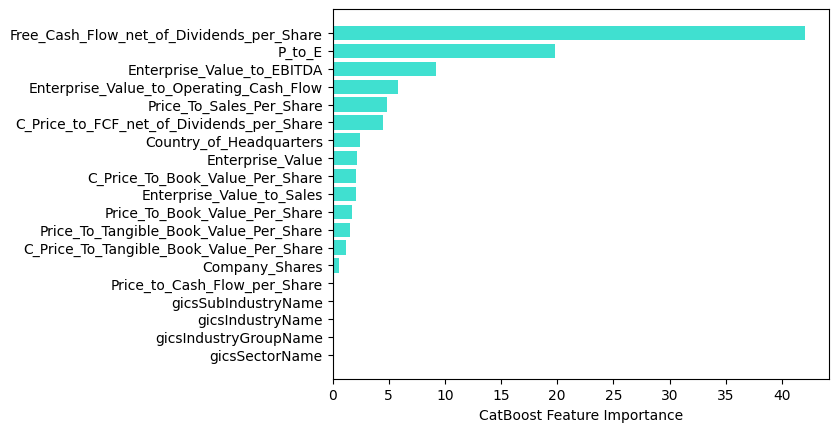

In [12]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(np.array(X_train.columns)[sorted_feature_importance],
        model.feature_importances_[sorted_feature_importance],
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [13]:
important_features = set(np.array(X_train.columns)[model.feature_importances_>0])
important_reg_columns = [el for el in reg_columns if el in important_features]
important_cat_columns = [el for el in cat_columns if el in important_features]

scaler = StandardScaler()

X_train, y_train = data[[el for el in cat_columns + reg_columns if el in important_features]], data.Perf_1Y
X_test, y_test = test[[el for el in cat_columns + reg_columns if el in important_features]], test.Perf_1Y

X_train.loc[:, important_reg_columns] = scaler.fit_transform(X_train.loc[:, important_reg_columns].to_numpy())
X_test.loc[:, important_reg_columns] = scaler.transform(X_test.loc[:, important_reg_columns].to_numpy())

train_dataset = cb.Pool(X_train, y_train, cat_features=important_cat_columns)
test_dataset = cb.Pool(X_test, y_test, cat_features=important_cat_columns)

/var/folders/6j/p61nyxsx25xd2l5m0h0g5bm80000gn/T/ipykernel_10241/804355520.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:, important_reg_columns] = scaler.fit_transform(X_train.loc[:, important_reg_columns].to_numpy())
/var/folders/6j/p61nyxsx25xd2l5m0h0g5bm80000gn/T/ipykernel_10241/804355520.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, important_reg_columns] = scaler.transform(X_test.loc[:, important_reg_columns].to_numpy())


In [14]:
model = cb.CatBoostRegressor(loss_function='MAE',
                             iterations=50)
model.fit(train_dataset, eval_set=test_dataset)

0:	learn: 0.4080736	test: 0.4584887	best: 0.4584887 (0)	total: 282ms	remaining: 13.8s
1:	learn: 0.4077177	test: 0.4583946	best: 0.4583946 (1)	total: 529ms	remaining: 12.7s
2:	learn: 0.4073794	test: 0.4583069	best: 0.4583069 (2)	total: 766ms	remaining: 12s
3:	learn: 0.4070678	test: 0.4582712	best: 0.4582712 (3)	total: 969ms	remaining: 11.1s
4:	learn: 0.4067727	test: 0.4582404	best: 0.4582404 (4)	total: 1.17s	remaining: 10.5s
5:	learn: 0.4064788	test: 0.4581905	best: 0.4581905 (5)	total: 1.37s	remaining: 10s
6:	learn: 0.4062046	test: 0.4581111	best: 0.4581111 (6)	total: 1.58s	remaining: 9.69s
7:	learn: 0.4059563	test: 0.4580402	best: 0.4580402 (7)	total: 1.77s	remaining: 9.32s
8:	learn: 0.4057126	test: 0.4580249	best: 0.4580249 (8)	total: 1.98s	remaining: 9.01s
9:	learn: 0.4054856	test: 0.4580007	best: 0.4580007 (9)	total: 2.17s	remaining: 8.69s
10:	learn: 0.4052661	test: 0.4579804	best: 0.4579804 (10)	total: 2.37s	remaining: 8.41s
11:	learn: 0.4050550	test: 0.4579090	best: 0.4579090 (11

In [15]:
res_df = evaluate(model, X_train, data.reset_index()[['Date_round', 'Perf_1Y']])
mean_res = res_df.mean()
print(f'Train score.\n'
      f'{res_df}\n\n'
      f'RMSE: {round(mean_res.rmse, 3)}\n'
      f'p_pred: {round(mean_res.p_pred, 3)}\n'
      f'ndcg: {round(mean_res.ndcgs, 3)}')

Train score.
                rmse    p_pred     ndcgs
Date_round                              
2007-04-01  0.925120  0.511881  0.933829
2007-07-01  0.814771  0.702140  0.934365
2007-10-01  0.501990  0.855455  0.934622
2008-01-01  0.577716  0.941580  0.934388
2008-04-01  0.520822  0.935480  0.936237
2008-07-01  0.420215  0.808637  0.934336
2008-10-01  0.552062  0.540891  0.934750
2009-01-01  1.775434  0.331429  0.938497
2009-04-01  2.145690  0.314883  0.937540
2009-07-01  1.020623  0.396351  0.938748
2009-10-01  0.735200  0.391037  0.936515
2010-01-01  0.727199  0.393163  0.937314
2010-04-01  0.899193  0.440823  0.939185
2010-07-01  0.837869  0.401010  0.939606
2010-10-01  0.726753  0.631722  0.939560
2011-01-01  0.725806  0.748432  0.938675
2011-04-01  0.709939  0.683362  0.937351
2011-07-01  0.640280  0.753424  0.939584
2011-10-01  0.608625  0.537611  0.938184
2012-01-01  0.613381  0.443008  0.937173
2012-04-01  0.698756  0.561976  0.940400
2012-07-01  0.911129  0.473154  0.940174
201

In [16]:
res_df = evaluate(model, X_test, test.reset_index()[['Date_round', 'Perf_1Y']])
mean_res = res_df.mean()
print(f'Test score.\n'
      f'{res_df}\n\n'
      f'RMSE: {round(mean_res.rmse, 3)}\n'
      f'p_pred: {round(mean_res.p_pred, 3)}\n'
      f'ndcg: {round(mean_res.ndcgs, 3)}')

Test score.
                rmse    p_pred     ndcgs
Date_round                              
2018-10-01  0.744010  0.628555  0.937784
2019-01-01  1.344534  0.473666  0.938363
2019-04-01  1.514447  0.735134  0.937398
2019-07-01  0.569084  0.633591  0.937894
2019-10-01  0.966841  0.509886  0.936104
2020-01-01  0.983855  0.427532  0.936602
2020-04-01  1.468920  0.243655  0.937658
2020-07-01  1.358398  0.246323  0.939511
2020-10-01  1.228743  0.314883  0.938815
2021-01-01  2.781798  0.400787  0.937236

RMSE: 1.296
p_pred: 0.461
ndcg: 0.938
